# Readme
The fb_json_key is not uploaded, and lstm is the trained model that is already saved.
The following code currently downloads all the data from Firebase, as our database grows, future versions should look into only downloading the latest data.


Run all the code except the last two cells. The last cell is the predicted next 2 hours' do level. Input of pond id is required. The one above this is used to plot all 6 pond's do on train/test/val sets and also future prediction.

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from datetime import timedelta
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pickle

In [2]:
## ONLY RUN ONCE! ###
# download data from firebase
try:
    firebase_admin.delete_app(app)
except:
    print('making new app')
cred = credentials.Certificate("fb_key.json")
app = firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})


making new app


In [3]:
# Remove outliers in DO and temperature lists
def outliers(lst):
    lst = np.array(lst)
    data = [x for x in lst if isinstance(x, (int, float, np.number))]
    if len(data) == 0:
        return np.nan
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    return filtered_data

def remove_outliers_from_df(df):

    for column in df.columns:
        df[column] = df[column].apply(outliers)

    return df

# Calculate the weighted mean of DO and temp
def calculate_weighted_mean(lst):
    num_double_weights = min(len(lst), 6)
    weights = [1] * (len(lst) - num_double_weights) + [2] * num_double_weights
    return np.average(lst, weights=weights)

def Convert_mean(df):
    for column in df.columns:
        df[column] = df[column].apply(calculate_weighted_mean)
    return df

In [4]:
def denormalize(predictions, mean, std):
    return predictions * std + mean

In [5]:
# Introduce time as another feature
def fix_time(data):
  datetime_object= pd.to_datetime(data.index, format='%Y%m%d_%H:%M:%S')
  # print(datetime_object)
  datetime_object= datetime_object.round('60min').to_pydatetime()
  # print(data['datetime'])
  # data['year'] =  pd.DatetimeIndex(data['datetime']).year
  # data['month'] =pd.DatetimeIndex(data['datetime']).month
  # data['day'] =pd.DatetimeIndex(data['datetime']).day
  # data['hour'] = pd.DatetimeIndex(datetime_object).hour
  # data.set_index('datetime', inplace = True)
  return data

In [6]:
# Incorportae all functions above, get processed temp and do data wth pond_id
def getData(pond_number):
    base_path = '/LH_Farm/pond_'
    pond = f"{base_path}{pond_number}"  #Get data from the firebase
    ref = db.reference(pond)
    data = ref.get()

    df = pd.DataFrame(data)

    # Only keeps do, pressure and temp columns
    #do = df.loc[['do','temp','pressure']]
    #do = df.iloc[0]
    do = df.loc[['do','temp','type']]
    do_res = pd.DataFrame(do)


    do_res = do_res.T
    do_res = do_res[do_res['type'] != 'truck']
    do_res = do_res.iloc[:,0:2]
    do_res = pd.DataFrame(do_res)
    do_res = do_res.T

    do_mean = Convert_mean(do_res) # Get mean of DO


    do_mean = do_mean.T

    #do_mean=fix_time(do_mean)

    with open('latest_data.json', 'w') as f:
        json.dump(data, f)

    return do_mean


In [7]:
# Plot up to date DO, temperature trend
def OriginalDoPlot(pond_id, ax):
    data = getData(pond_id)

    ax.plot(data['do'], marker='o', label = 'DO')
    ax.plot(data['temp'], marker='o', label = 'Temp')
    ax.set_title('Time-Series Prediction for pond %d'%pond_id)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Change interval as needed
    ax.xaxis.set_tick_params(rotation=45)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.tight_layout()


In [11]:
# Get data from all six ponds
def getAllData():
  res = []
  data_59 = getData(59)
  data_60 = getData(60)
  data_61 = getData(61)
  data_65 = getData(65)
  data_66 = getData(66)
  data_67 = getData(67)
  res.append(data_59)
  res.append(data_60)
  res.append(data_61)
  res.append(data_65)
  res.append(data_66)
  res.append(data_67)

  return res
#data_62 = getData(62)
#data_68 = getData(68)


In [13]:
def plot_all_Original():
  fig, axes = plt.subplots(3, 2, figsize=(20,15))
  axes = axes.flatten()
  # print(axes)

  for i, axe in enumerate(axes):
      id = [59,60,61,65,66,67]
      OriginalDoPlot(id[i], axe)

In [14]:
# Sliding windows used to split data to x and y
def sliding_windows(data, seq_length, n_future):
    x = []
    y = []

    for i in range(len(data)-seq_length - n_future + 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+seq_length+n_future].T[0]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [15]:
def Load_Data(data):
    scaler = StandardScaler()     # Scale the input
    scaler.fit(data)
    mean = scaler.mean_
    std = np.sqrt(scaler.var_)
    training_data = scaler.transform(data)

    seq_length = 4    # Choose params for sliding window, use 4 to predict 2 futures here
    n_future = 2
    x, y = sliding_windows(training_data, seq_length, n_future)
    #print(x.shape, y.shape
    scaler = StandardScaler()

    train_size = int(len(y) * 0.7) # Split the datasets to train/val/test
    val_size = int(len(y) * 0.2)
    test_size = len(y) - train_size - val_size

    dataX = Variable(torch.Tensor(np.array(x))) # Convert to tensor
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    valX = Variable(torch.Tensor(np.array(x[train_size:train_size+val_size])))
    valY = Variable(torch.Tensor(np.array(y[train_size:train_size+val_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size+val_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size+val_size:len(y)])))

    trainX = torch.tensor(trainX, dtype=torch.float32)


    return trainX, trainY, valX, valY, testX, testY, dataX, dataY, train_size, val_size, mean, std

In [16]:
def train_test_split():
  res = getAllData()
  train_X = []
  train_Y = []
  val_X = []
  val_Y = []
  test_X = []
  test_Y = []
  # Integrate all ponds data together to build one model
  for i in res:
      train_x, train_y, val_x, val_y, test_x, test_y,_,_,_,_,_,_ = Load_Data(i)
      train_X.extend(train_x)
      train_Y.extend(train_y)
      val_X.extend(val_x)
      val_Y.extend(val_y)
      test_X.extend(test_x)
      test_Y.extend(test_y)
  train_X = Variable(torch.Tensor(np.array(train_X)))
  train_Y = Variable(torch.Tensor(np.array(train_Y)))
  val_X = Variable(torch.Tensor(np.array(val_X)))
  val_Y = Variable(torch.Tensor(np.array(val_Y)))
  test_X = Variable(torch.Tensor(np.array(test_X)))
  test_Y = Variable(torch.Tensor(np.array(test_Y)))

  return train_X, train_Y, val_X, val_Y, test_X, test_Y

# print(train_Y.shape, train_X.shape, test_Y.shape, test_X.shape)

In [17]:
'''class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out
        '''

In [18]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [19]:
def custom_loss(y_pred, y_true):
    mse_loss = F.mse_loss(y_pred, y_true)  # Mean Squared Error (MSE)
    penalty = torch.mean(torch.relu(y_pred - y_true) ** 2)  # Penalty for y_pred > y_true
    return mse_loss + penalty

In [20]:
def calculate_mae(y_pred, y_true):
    #Calculates the Mean Absolute Error (MAE)
    return torch.mean(torch.abs(y_pred - y_true))

def calculate_rmse(y_pred, y_true):
    #Calculates the Root Mean Squared Error (RMSE)
    return torch.sqrt(F.mse_loss(y_pred, y_true))


In [ ]:
"""train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []

train_X, train_Y, val_X, val_Y, test_X, test_Y = train_test_split()
input_size = 2 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
num_classes = 2
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
n_epochs = 3000
learning_rate = 0.001 # 0.001 lr
# loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=700, verbose=False)
for epoch in range(n_epochs):
      lstm.train()
      outputs = lstm(train_X) # forward pass
      optimiser.zero_grad() # calculate the gradient, manually setting to 0
      # obtain the loss function
      loss = custom_loss(outputs, train_Y)
      train_losses.append(loss)
      train_mae = calculate_mae(outputs, train_Y)
      train_rmse = calculate_rmse(outputs, train_Y)
      loss.backward() # calculates the loss of the loss function
      optimiser.step() # improve from loss, i.e backprop
      # test loss
      lstm.eval()
      val_preds = lstm(val_X)
      val_loss = custom_loss(val_preds, val_Y)
      val_losses.append(val_loss)
      val_mae = calculate_mae(val_preds, val_Y)
      val_rmse = calculate_rmse(val_preds, val_Y)


      #if epoch % 100 == 0:
        #print("-" * 40)
        #print("Epoch: {}".format(epoch))
        #print("-" * 40)
        #print("{:<15} {:<15} {:<15} ".format('Metric', 'Train', 'Validation', 'Test'))
        #print("-" * 40)
        #print("{:<15} {:<15.5f} {:<15.5f} ".format('Loss', loss.item(), val_loss.item()))
        #print("{:<15} {:<15.5f} {:<15.5f} ".format('MAE', train_mae.item(), val_mae.item()))
        #print("{:<15} {:<15.5f} {:<15.5f} ".format('RMSE', train_rmse.item(), val_rmse.item()))
      if epoch % 100 == 0:
          print("Epoch: %d, train loss: %1.5f, val loss: %1.5f" % (epoch, loss.item(), val_loss.item()))
      early_stopping(val_loss.item(), lstm)
      if early_stopping.early_stop:
         print("Early stopping")
         break
         """


'train_losses = []\ntrain_accuracies = []\nval_losses = []\nval_accuracies = []\ntest_losses = []\n\ntrain_X, train_Y, val_X, val_Y, test_X, test_Y = train_test_split()\ninput_size = 2 # number of features\nhidden_size = 2 # number of features in hidden state\nnum_layers = 1 # number of stacked lstm layers\nnum_classes = 2\nlstm = LSTM(num_classes, input_size, hidden_size, num_layers)\nn_epochs = 3000\nlearning_rate = 0.001 # 0.001 lr\n# loss_fn = torch.nn.MSELoss()    # mean-squared error for regression\noptimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)\nearly_stopping = EarlyStopping(patience=700, verbose=False)\nfor epoch in range(n_epochs):\n      lstm.train()\n      outputs = lstm(train_X) # forward pass\n      optimiser.zero_grad() # calculate the gradient, manually setting to 0\n      # obtain the loss function\n      loss = custom_loss(outputs, train_Y)\n      train_losses.append(loss)\n      train_mae = calculate_mae(outputs, train_Y)\n      train_rmse = calcul

In [ ]:
'''ith open('lstm', 'wb') as file:
    pickle.dump(lstm, file)'''

"ith open('lstm', 'wb') as file:\n    pickle.dump(lstm, file)"

In [21]:
with open('lstm', 'rb') as file:
    lstm = pickle.load(file)

In [22]:
# Calculate test Loss/MAE/RMSE
def test_stats():
  train_X, train_Y, val_X, val_Y, test_X, test_Y = train_test_split()
  test_preds = lstm(test_X)
  test_loss = custom_loss(test_preds, test_Y)
  test_mae = calculate_mae(test_preds, test_Y)
  test_rmse = calculate_rmse(test_preds, test_Y)
  print("-" * 20)
  print("Test Set Metrics:")
  print("-" * 20)
  print("Test MAE: {:.5f}".format(test_loss.item()))
  print("Test MAE: {:.5f}".format(test_mae.item()))
  print("Test RMSE: {:.5f}".format(test_rmse.item()))

In [23]:
#test_stats()

<ipython-input-15-38621ee99be7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX = torch.tensor(trainX, dtype=torch.float32)
<ipython-input-15-38621ee99be7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX = torch.tensor(trainX, dtype=torch.float32)
<ipython-input-15-38621ee99be7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX = torch.tensor(trainX, dtype=torch.float32)
<ipython-input-15-38621ee99be7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

--------------------
Test Set Metrics:
--------------------
Test MAE: 0.44767
Test MAE: 0.45014
Test RMSE: 0.64393


In [24]:
def loss_plot():
  train_X, train_Y, val_X, val_Y, test_X, test_Y = train_test_split()
  plt.figure(figsize=(12, 5))
  # Plotting the loss
  plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), [loss.detach().numpy() for loss in train_losses], label='Train Loss')
  plt.plot(range(len(val_losses)), [loss.detach().numpy() for loss in val_losses], label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss (MSE)')
  plt.title('Loss over Epochs')
  plt.title('(a)',loc='left',x=-0.08, y=1,fontsize=13)
  plt.legend()



  plt.tight_layout()
  plt.show()

In [25]:
def Predict(pond_id):
    data = getData(pond_id)
    _, _, _, _, _, _, dataX ,dataY,train_size,val_size, mean,std = Load_Data(data)

    do = data.iloc[:,:]

    # Use 4 last observations as last sequence to predict next two in future
    lastDay = do.tail(4)

    # scale the input
    scaler = StandardScaler()
    scaler.fit(lastDay)
    mean0 = scaler.mean_
    std0 = np.sqrt(scaler.var_)
    lastDay = scaler.transform(lastDay)

    # Convert to tensor, shape it to fit the model
    last_sequence = Variable(torch.Tensor(np.array(lastDay)))
    last_sequence = last_sequence.unsqueeze(0)
    last_sequence = last_sequence.reshape(last_sequence.shape[1], last_sequence.shape[2])
    last_sequence = scaler.transform(last_sequence)
    last_sequence = Variable(torch.Tensor(np.array(last_sequence)))
    last_sequence = last_sequence.unsqueeze(0)

    # Get the prediction result and denormalize it, convert to numpy
    future_predict = lstm(last_sequence)
    future_predict = denormalize(future_predict, mean0[0], std0[0])
    future_predict = future_predict.detach().numpy()
    future_predict = future_predict.reshape(-1,1)

    # Get the index of prediction result
    future_indices = np.arange(len(do), len(do) + len(future_predict))

    return dataX, do, future_predict, future_indices,train_size, val_size, mean,std

In [28]:
def GetPredictedDo(pond_id):
  _, _, future_predict, _, _, _, _,_ = Predict(pond_id)
  print(future_predict[0], future_predict[1])
  return future_predict[0], future_predict[1]

In [26]:
def Plotting(pond_id,ax):
    dataX, do, future_predict, future_indices,train_size,val_size, mean,std = Predict(pond_id)
    # Get prediction result on train/val/test sets and plots
    do = do.iloc[2:, :1]

    train_predict = lstm(dataX)

    last_train= train_predict[-1,1:]


    train_predict = train_predict[:,0].reshape(-1,1)

    last_train = last_train.reshape(-1, 1)

    train_predict = torch.cat((train_predict, last_train), dim=0)


    data_predict = train_predict.data.numpy()
    data_predict = denormalize(data_predict, mean[0], std[0])



    ax.plot(do, color = 'blue', label = 'Original Data')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

    ax.axvline(x=train_size, c='y', linestyle='--', label = 'Train-Val-split')
    ax.axvline(x=train_size+val_size, c='y', linestyle='--', label = 'Val-Test-split')
    ax.axvline(x=len(do), color='r', linestyle='--', label='Prediction Boundary')
    ax.plot(data_predict, color = 'orange', marker='.', label = 'Predicted Data')
    ax.plot(future_indices , future_predict, color='green', marker='.',label='Future Predicted Data')
    ax.legend()
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title('Time-Series Prediction for pond %d'%pond_id)
    plt.tight_layout()



<ipython-input-15-38621ee99be7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX = torch.tensor(trainX, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-15-38621ee99be7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX = torch.tensor(trainX, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-15-38621ee99be7>:30: UserWarning: To copy construct from a te

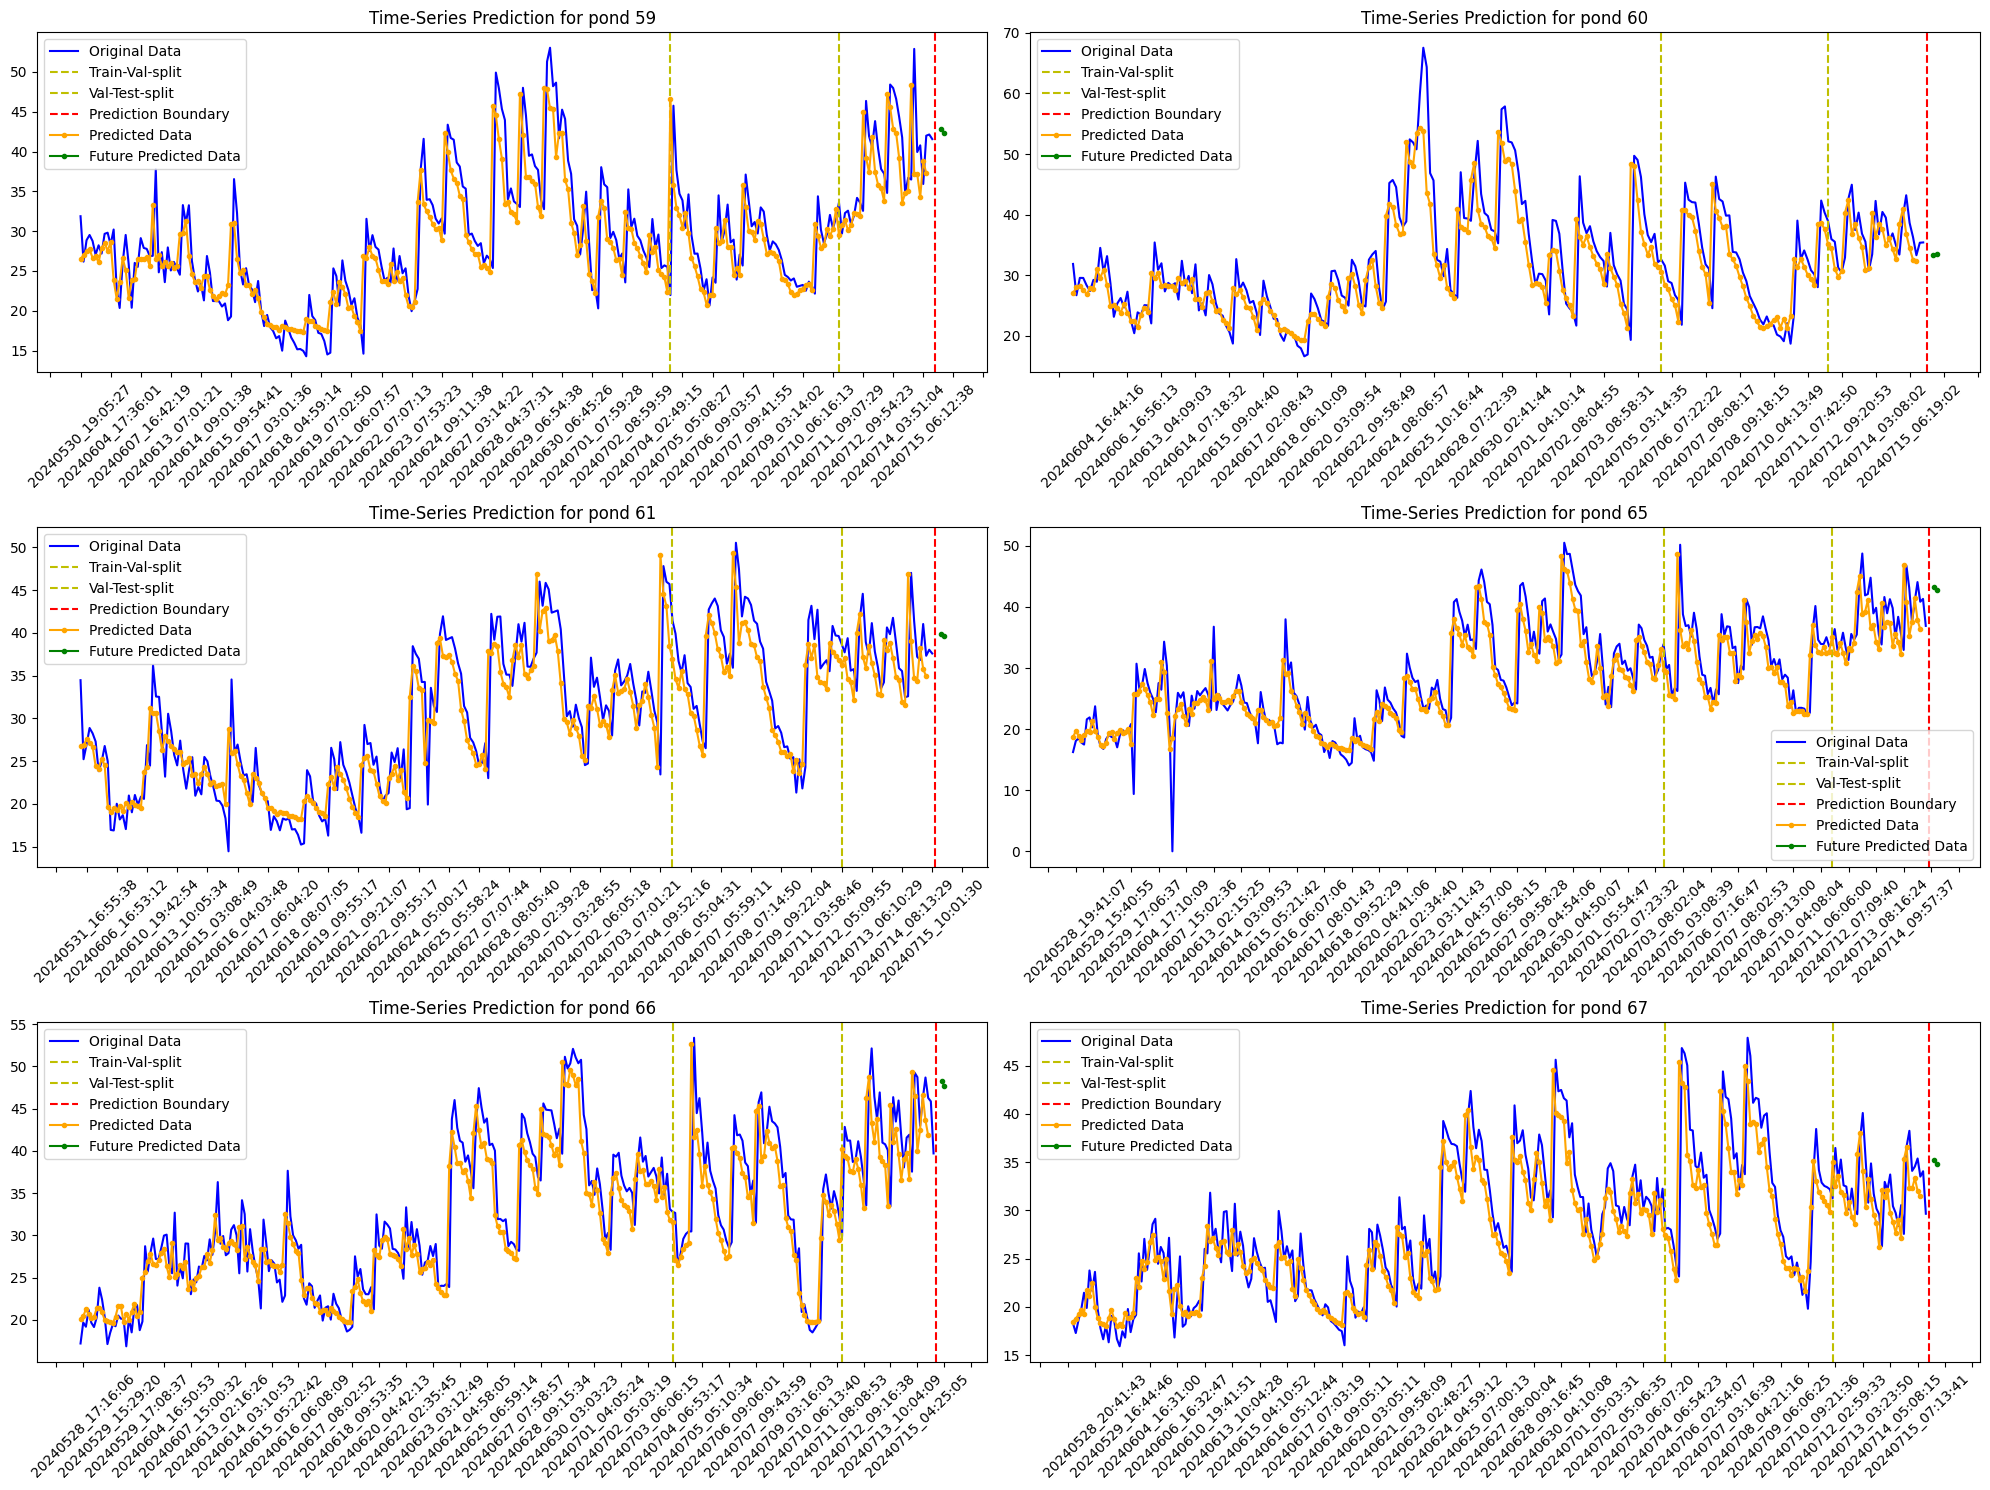

In [27]:
# Run this to Get all 6 plots with predicton
fig, axes = plt.subplots(3, 2, figsize=(20,15))
axes = axes.flatten()
# print(axes)

for i, axe in enumerate(axes):
  id = [59,60,61,65,66,67]
  Plotting(id[i], axe)

In [29]:
# Run this to get the predicted future 2 hours' do, input the pond number you want to predict
# The pond can be
GetPredictedDo(59)

[42.82871] [42.375294]


<ipython-input-15-38621ee99be7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX = torch.tensor(trainX, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(array([42.82871], dtype=float32), array([42.375294], dtype=float32))